In [2]:
!pip install gensim numpy matplotlib seaborn pandas scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.9 MB/s eta 0:00:00


Loading embeddings from OperaLatina.vec.txt ...
Loaded. Vocabulary size: 14101
Loading embeddings from OperaMaiora.vec.txt ...
Loaded. Vocabulary size: 14101

Common vocabulary size: 14101

PHASE 1: GLOBAL STATISTICS & HISTOGRAM
Computing cosine similarities for FULL vocabulary...


Global Calc: 100%|██████████| 14101/14101 [00:00<00:00, 85521.80it/s]


--- STATISTICS ---
Mean (μ): -0.1476
Median:   -0.1494
Std (σ):  0.1739
Normal range (±1σ): [-0.3216, 0.0263]
Empirical Rule Check:
  In μ ± 1σ: 65.51% (theory ~68%)
  In μ ± 2σ: 96.63% (theory ~95%)



Top 10 Most Shifted (Lowest Similarity):
       word  similarity
    laocoon   -0.708322
     chelys   -0.687160
      iapyx   -0.682218
hamadryades   -0.680795
    pegasus   -0.671241
     cybebe   -0.661245
  sisyphius   -0.649537
    chalybs   -0.634604
   parnasus   -0.629701
    sipylus   -0.628184

Top 10 Most Stable (Highest Similarity):
    word  similarity
  myrrha    0.511197
    ruga    0.498629
  saliua    0.474835
foetidus    0.471354
 pinguis    0.453921
  stillo    0.444813
assyrius    0.442899
 cortina    0.435491
  culter    0.416688
  passer    0.414429

Histogram saved as 'semantic_shift_histogram_combined.png'


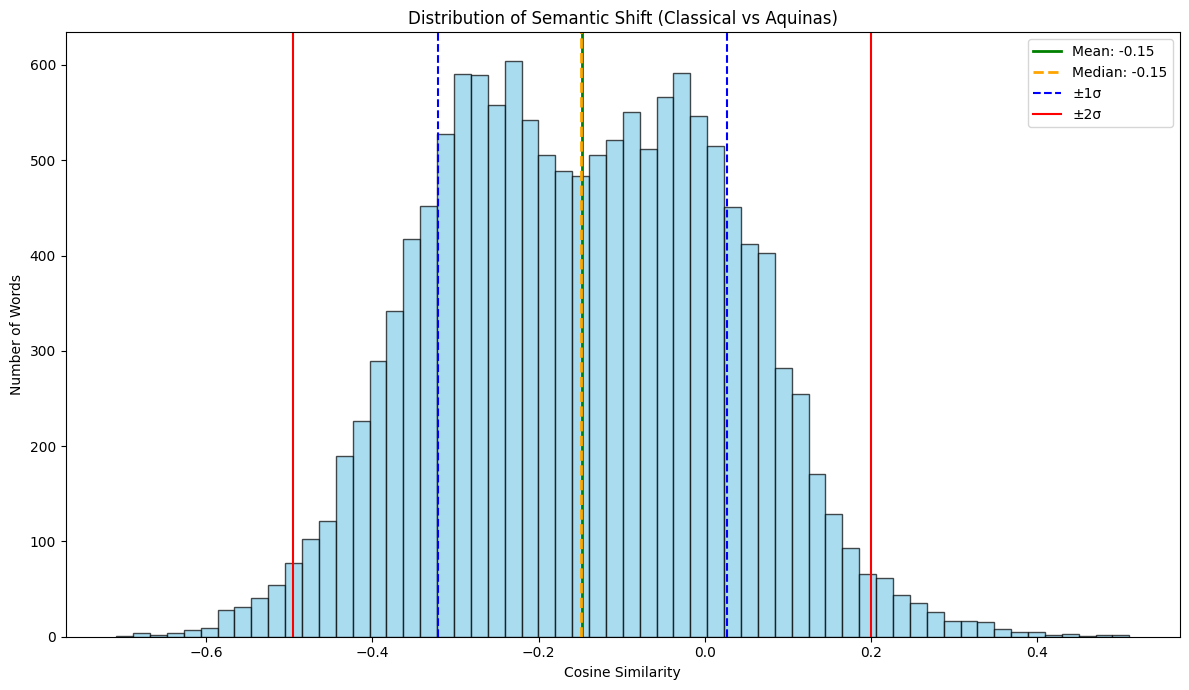


PHASE 2: FOCUSED ANALYSIS (Selected Words)

Semantic Shift for Selected Words:
       word  similarity
   ecclesia   -0.320712
        lex   -0.232794
    ciuitas   -0.196893
    populus   -0.144693
christianus   -0.123373
  multitudo   -0.122616
      plebs   -0.103586
    familia   -0.086470
   princeps   -0.066015
 respublica   -0.062060
       deus   -0.049356
     stirps   -0.045451
      ciuis   -0.034893
     regnum   -0.034338
      fides   -0.022381
      natio   -0.013743
  patricius   -0.010792
   tumultus   -0.004233
     uulgus    0.018743
     lingua    0.019548
        rex    0.037749
      turba    0.042004
      genus    0.100089
       gens    0.108994
   imperium    0.206174
Bar chart saved as 'focused_words_barchart.png'


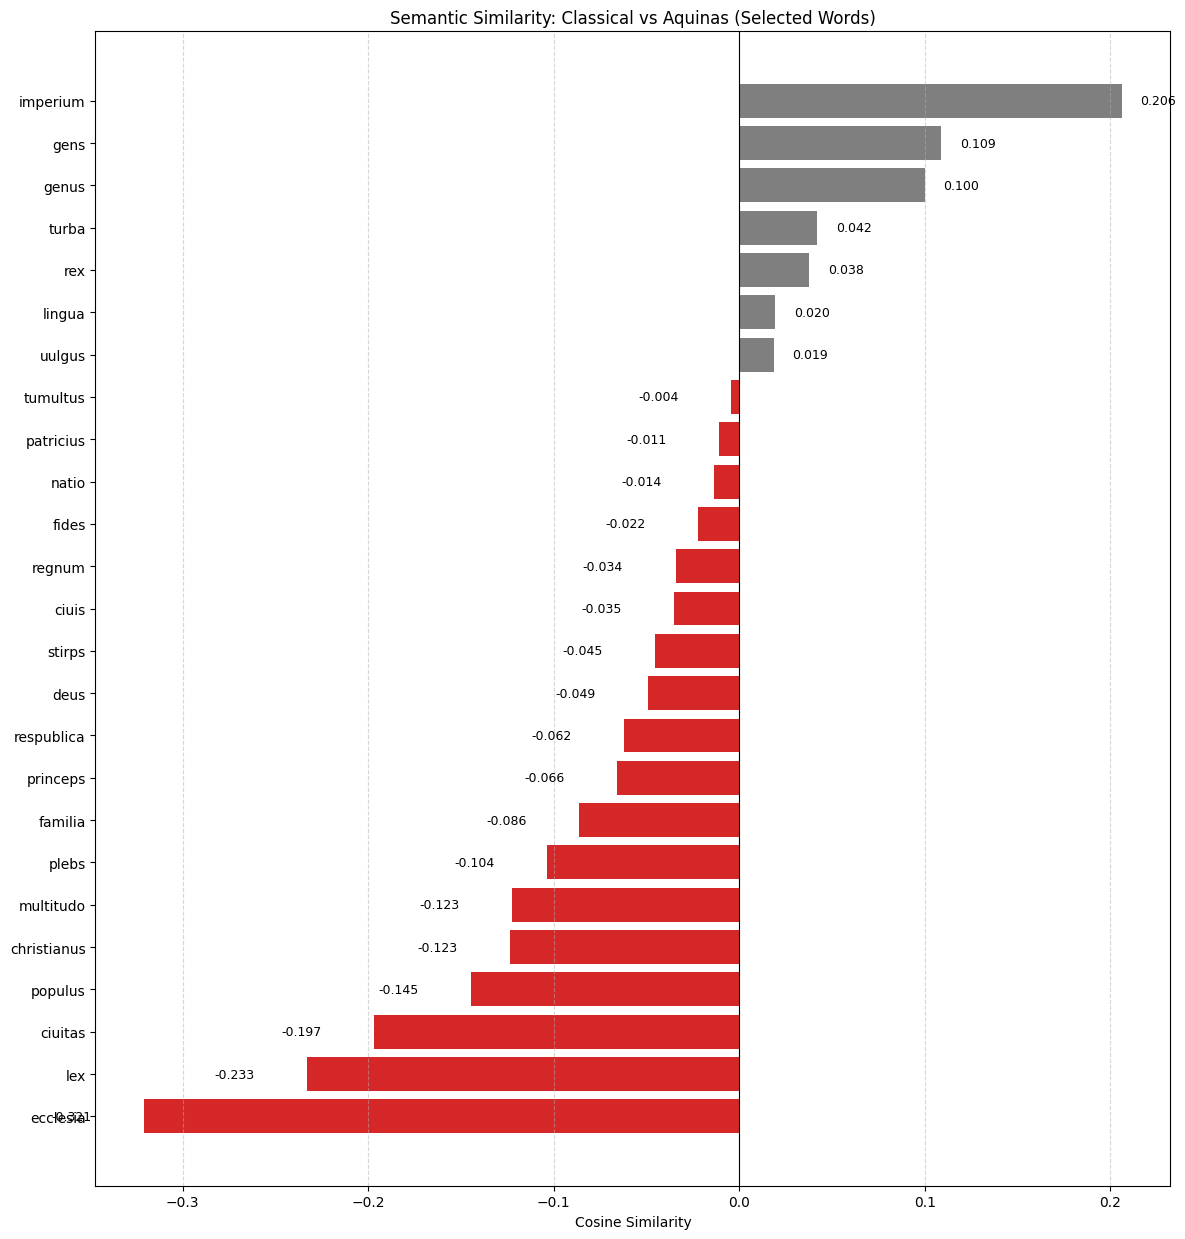


Building heatmaps for 15 words...


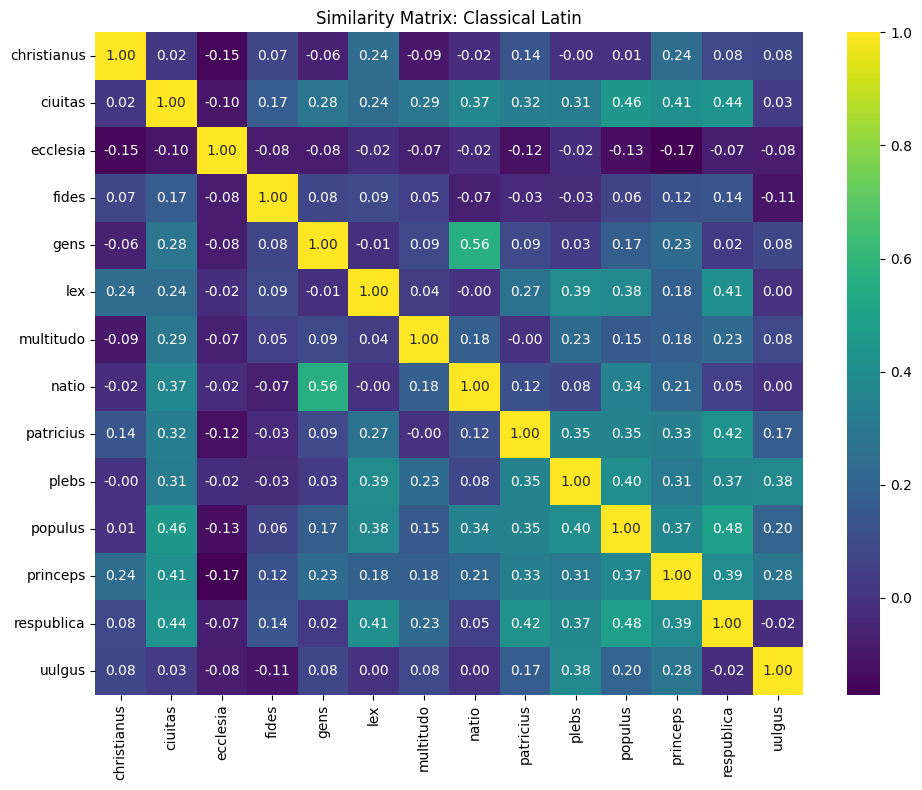

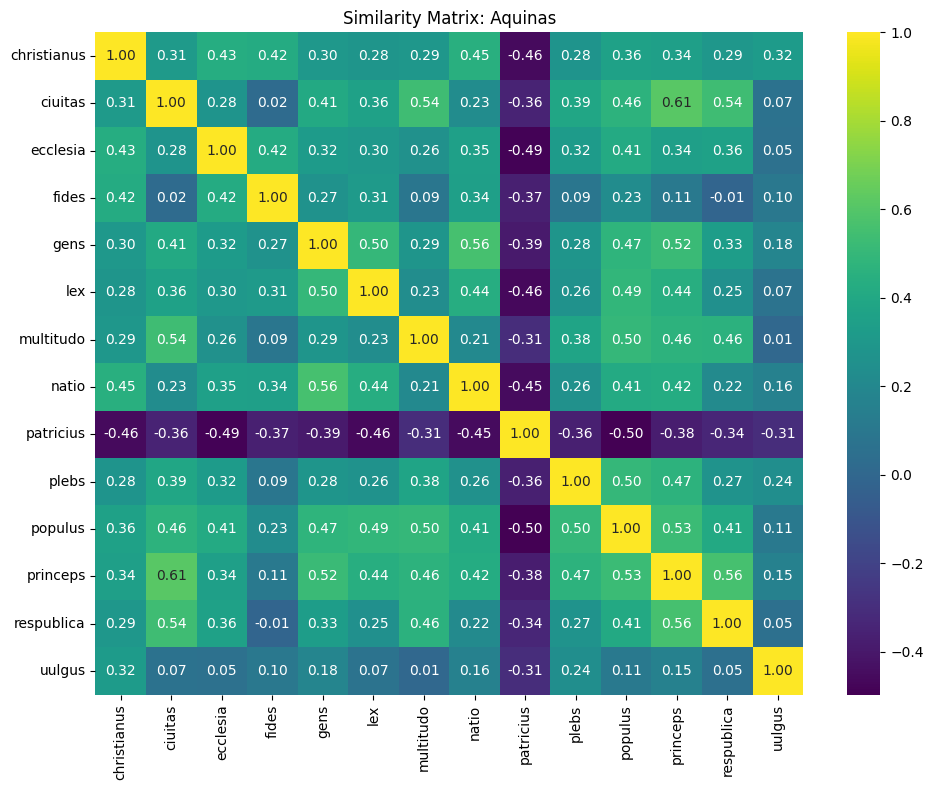

Heatmaps saved.


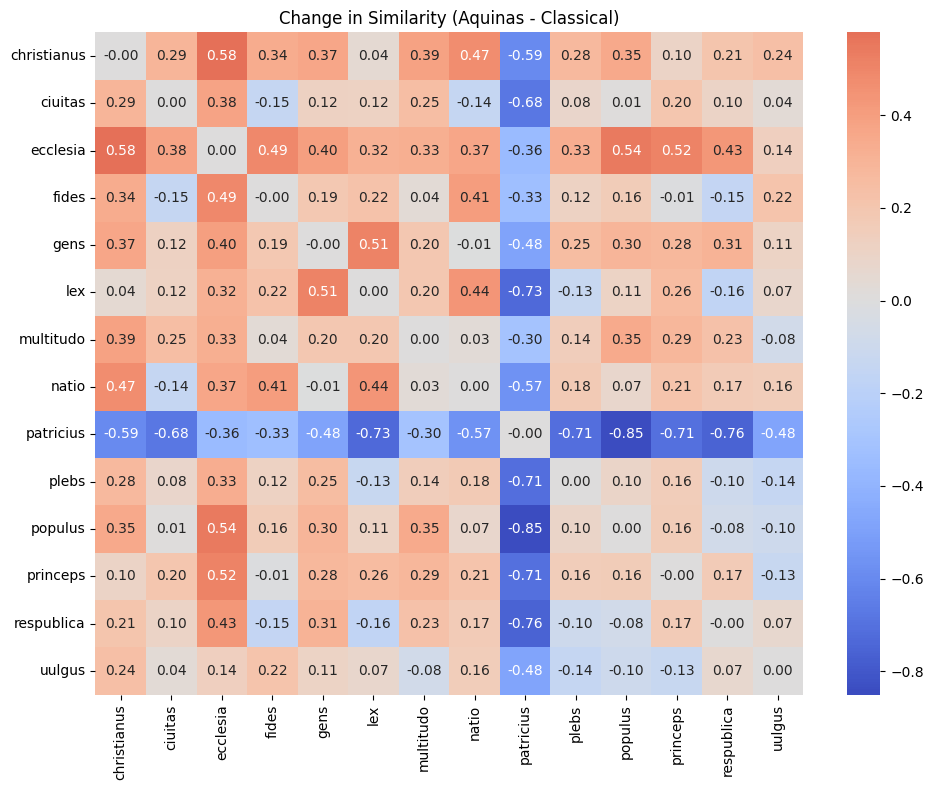

Projection saved as 'viz_pca.png'


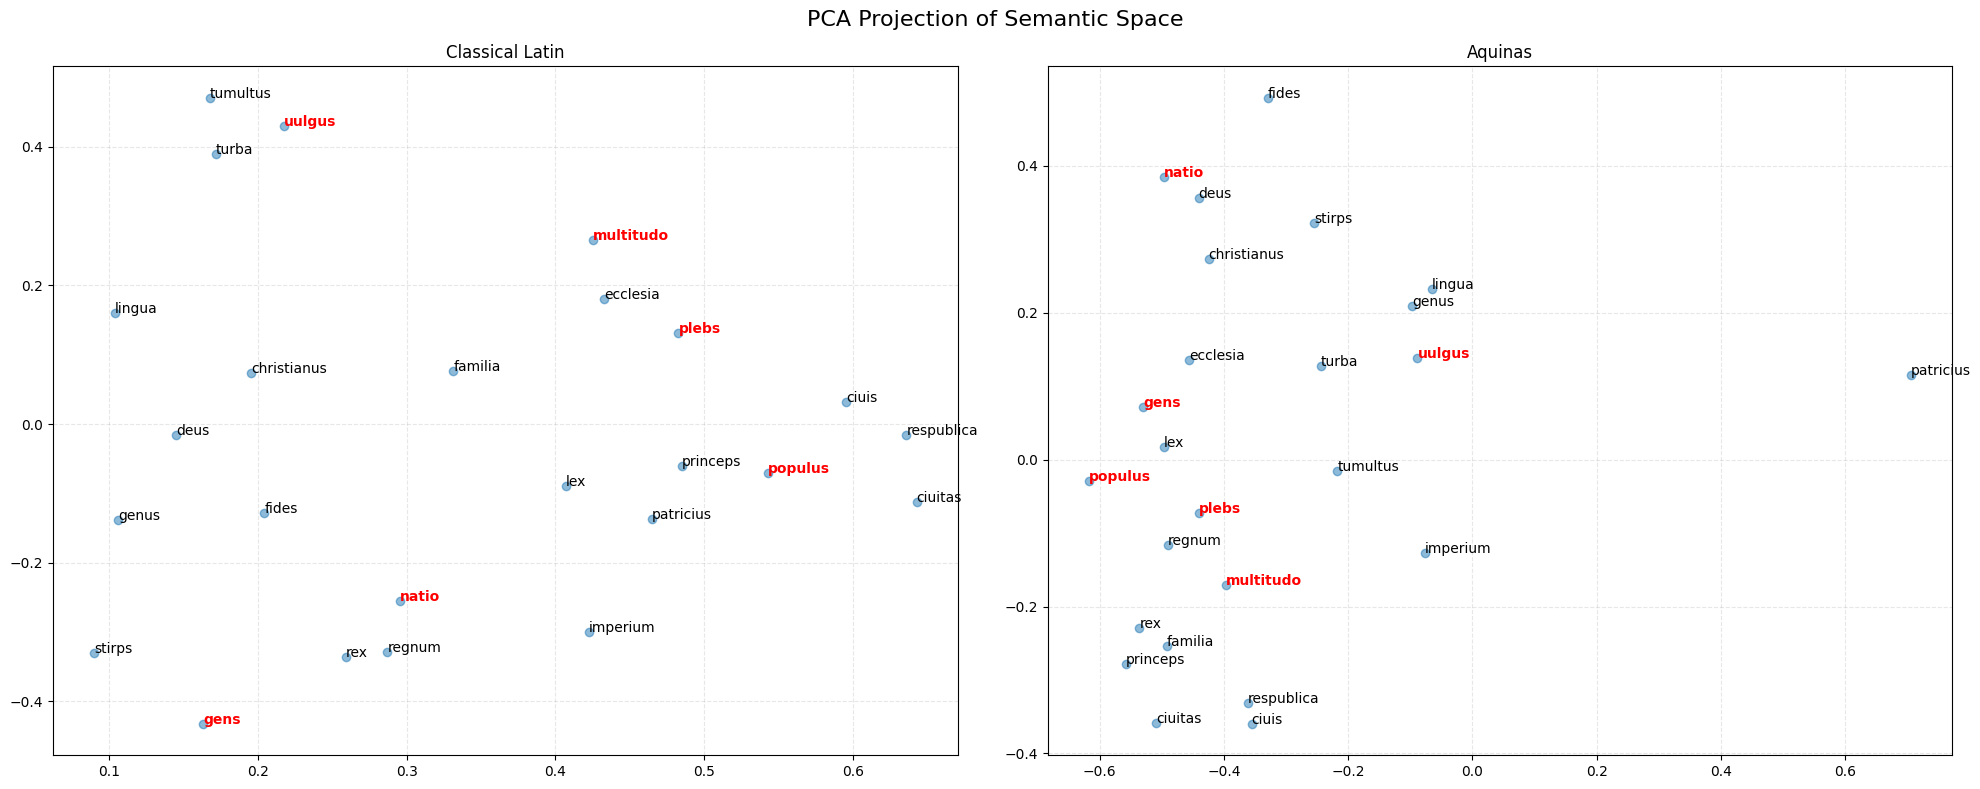


--- NEAREST NEIGHBORS REPORT ---

=== POPULUS ===
Classical Neighbor        Sim        | Aquinas Neighbor          Sim       
---------------------------------------------------------------------------
romanus                   0.5604     | optimas                   0.6166    
ciuis                     0.5572     | typus                     0.6000    
popularis                 0.5369     | popularis                 0.5947    
populatio                 0.5340     | israel                    0.5906    
populariter               0.5179     | aaron                     0.5896    
populo                    0.5159     | coetus                    0.5744    
decemuir                  0.5056     | iudaicus                  0.5653    
foederatus                0.4913     | leuiticus                 0.5574    
senatus                   0.4864     | samaritanus               0.5544    
duumuir                   0.4862     | colonus                   0.5481    
respublica                0.4828     

In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors
from numpy.linalg import norm
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Отключаем лишние предупреждения
warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================
CLASSICAL_MODEL_URL = 'https://embeddings.lila-erc.eu/samples/download/aligned/OperaLatina.vec.txt'
AQUINAS_MODEL_URL   = 'https://embeddings.lila-erc.eu/samples/download/aligned/OperaMaiora.vec.txt'

CLASSICAL_FILE = "OperaLatina.vec.txt"
AQUINAS_FILE   = "OperaMaiora.vec.txt"

# Списки слов для детального анализа
CORE_CONCEPTS = [
    "populus", "plebs", "gens", "natio", "uulgus", "multitudo"
]

SEMANTIC_ANCHORS = [
    "ciuitas", "ciuis", "patricius", "respublica", "lex",
    "genus", "stirps", "familia", "regnum", "rex", "princeps",
    "imperium", "fides", "ecclesia", "christianus", "deus",
    "lingua", "turba", "tumultus"
]

HEATMAP_WORDS = sorted(list(set(CORE_CONCEPTS + [
    "ecclesia", "ciuitas", "patricius", "fides", "lex",
    "ciues", "respublica", "princeps", "christianus"
])))

ALL_ANALYSIS_WORDS = sorted(list(set(CORE_CONCEPTS + SEMANTIC_ANCHORS + HEATMAP_WORDS)))


# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def download_if_missing(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename} ...")
        os.system(f"wget -O {filename} {url}")
    else:
        print(f"{filename} already exists, skipping download.")

def load_model(filename):
    print(f"Loading embeddings from {filename} ...")
    model = KeyedVectors.load_word2vec_format(filename, binary=False)
    print(f"Loaded. Vocabulary size: {len(model.key_to_index)}")
    return model

def get_cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

def get_vectors_for_words(model, words):
    vectors, valid_words = [], []
    for w in words:
        if w in model:
            vectors.append(model[w])
            valid_words.append(w)
    return np.array(vectors), valid_words

def plot_projection(coords_cl, coords_aq, words, title, filename):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    def plot_single(ax, coords, plot_title):
        ax.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
        for i, txt in enumerate(words):
            color = 'red' if txt in CORE_CONCEPTS else 'black'
            weight = 'bold' if txt in CORE_CONCEPTS else 'normal'
            ax.annotate(txt, (coords[i, 0], coords[i, 1]), color=color, fontweight=weight)
        ax.set_title(plot_title)
        ax.grid(True, linestyle='--', alpha=0.3)

    plot_single(axes[0], coords_cl, "Classical Latin")
    plot_single(axes[1], coords_aq, "Aquinas")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"Projection saved as '{filename}'")
    plt.show()


# ==========================================
# 3. MAIN PIPELINE
# ==========================================

# --- 3.1 Загрузка моделей ---
download_if_missing(CLASSICAL_MODEL_URL, CLASSICAL_FILE)
download_if_missing(AQUINAS_MODEL_URL, AQUINAS_FILE)

model_classical = load_model(CLASSICAL_FILE)
model_aquinas   = load_model(AQUINAS_FILE)
common_vocab = list(set(model_classical.key_to_index) & set(model_aquinas.key_to_index))
print(f"\nCommon vocabulary size: {len(common_vocab)}")


# --- 3.2 GLOBAL ANALYSIS (Statistics & Histogram) ---
print("\n" + "="*40)
print("PHASE 1: GLOBAL STATISTICS & HISTOGRAM")
print("="*40)

print("Computing cosine similarities for FULL vocabulary...")
global_sims = []
for lemma in tqdm(common_vocab, desc="Global Calc"):
    sim = get_cosine_similarity(model_classical[lemma], model_aquinas[lemma])
    global_sims.append((lemma, sim))

df_global = pd.DataFrame(global_sims, columns=['word', 'similarity'])
cos_values = df_global['similarity'].values

# Статистика
mu = cos_values.mean()
sigma = cos_values.std(ddof=1)
median = np.median(cos_values)
sd1_low, sd1_high = mu - sigma, mu + sigma
sd2_low, sd2_high = mu - 2*sigma, mu + 2*sigma

print(f"\n--- STATISTICS ---")
print(f"Mean (μ): {mu:.4f}")
print(f"Median:   {median:.4f}")
print(f"Std (σ):  {sigma:.4f}")
print(f"Normal range (±1σ): [{sd1_low:.4f}, {sd1_high:.4f}]")

# Проверка распределения
p_1sigma = ((cos_values >= sd1_low) & (cos_values <= sd1_high)).mean()
p_2sigma = ((cos_values >= sd2_low) & (cos_values <= sd2_high)).mean()
print(f"Empirical Rule Check:")
print(f"  In μ ± 1σ: {p_1sigma*100:.2f}% (theory ~68%)")
print(f"  In μ ± 2σ: {p_2sigma*100:.2f}% (theory ~95%)")

# Топ-10 списки
df_sorted = df_global.sort_values('similarity')
print("\nTop 10 Most Shifted (Lowest Similarity):")
print(df_sorted.head(10).to_string(index=False))
print("\nTop 10 Most Stable (Highest Similarity):")
print(df_sorted.tail(10).iloc[::-1].to_string(index=False))

# Гистограмма
plt.figure(figsize=(12, 7))
plt.hist(cos_values, bins=60, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mu, color='green', linewidth=2, label=f'Mean: {mu:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(sd1_low, color='blue', linestyle='--', label=f'±1σ')
plt.axvline(sd1_high, color='blue', linestyle='--')
plt.axvline(sd2_low, color='red', linestyle='-', label=f'±2σ')
plt.axvline(sd2_high, color='red', linestyle='-')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Words')
plt.title('Distribution of Semantic Shift (Classical vs Aquinas)')
plt.legend()
plt.tight_layout()
plt.savefig('semantic_shift_histogram_combined.png', dpi=300)
print("\nHistogram saved as 'semantic_shift_histogram_combined.png'")
plt.show()

# Сохранение полной таблицы
df_global.to_csv('classical_aquinas_cosine_full.csv', index=False)


# --- 3.3 FOCUSED ANALYSIS (Details) ---
print("\n" + "="*40)
print("PHASE 2: FOCUSED ANALYSIS (Selected Words)")
print("="*40)

# Расчет сдвигов для избранных слов
focused_sims = []
for word in ALL_ANALYSIS_WORDS:
    if word in model_classical and word in model_aquinas:
        sim = get_cosine_similarity(model_classical[word], model_aquinas[word])
        focused_sims.append((word, sim))

df_focused = pd.DataFrame(focused_sims, columns=['word', 'similarity']).sort_values('similarity')
df_focused.to_csv('focused_words_shifts.csv', index=False)

print("\nSemantic Shift for Selected Words:")
print(df_focused.to_string(index=False))

# Bar Chart с аннотациями
plt.figure(figsize=(12, len(df_focused)*0.5))
colors = ['#d62728' if x < 0 else '#7f7f7f' for x in df_focused['similarity']]
bars = plt.barh(df_focused['word'], df_focused['similarity'], color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Semantic Similarity: Classical vs Aquinas (Selected Words)')
plt.xlabel('Cosine Similarity')
plt.grid(axis='x', linestyle='--', alpha=0.5)

for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.01 if width >= 0 else width - 0.05
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
             va='center', fontsize=9, color='black')

plt.tight_layout()
plt.savefig('focused_words_barchart.png', dpi=300)
print("Bar chart saved as 'focused_words_barchart.png'")
plt.show()


# --- 3.4 HEATMAPS ---
print(f"\nBuilding heatmaps for {len(HEATMAP_WORDS)} words...")
vecs_cl, valid_cl = get_vectors_for_words(model_classical, HEATMAP_WORDS)
vecs_aq, valid_aq = get_vectors_for_words(model_aquinas, HEATMAP_WORDS)

if len(valid_cl) > 1:
    # Classical
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_similarity(vecs_cl), annot=True, fmt=".2f", cmap="viridis",
                xticklabels=valid_cl, yticklabels=valid_cl)
    plt.title("Similarity Matrix: Classical Latin")
    plt.tight_layout()
    plt.savefig('heatmap_classical.png', dpi=300)
    plt.show()

    # Aquinas
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_similarity(vecs_aq), annot=True, fmt=".2f", cmap="viridis",
                xticklabels=valid_aq, yticklabels=valid_aq)
    plt.title("Similarity Matrix: Aquinas")
    plt.tight_layout()
    plt.savefig('heatmap_aquinas.png', dpi=300)
    plt.show()

    # Difference
    diff_matrix = cosine_similarity(vecs_aq) - cosine_similarity(vecs_cl)
    plt.figure(figsize=(10, 8))
    sns.heatmap(diff_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                xticklabels=valid_cl, yticklabels=valid_cl)
    plt.title("Change in Similarity (Aquinas - Classical)")
    plt.tight_layout()
    plt.savefig('heatmap_difference.png', dpi=300)
    print("Heatmaps saved.")
    plt.show()


# --- 3.5 PCA PROJECTION ---
words_viz = [w for w in ALL_ANALYSIS_WORDS if w in common_vocab]
v_cl_viz, _ = get_vectors_for_words(model_classical, words_viz)
v_aq_viz, _ = get_vectors_for_words(model_aquinas, words_viz)
combined_vectors_viz = np.vstack([v_cl_viz, v_aq_viz])

if combined_vectors_viz.shape[0] > 2:
    pca = PCA(n_components=2, random_state=42)
    coords_pca = pca.fit_transform(combined_vectors_viz)
    coords_cl_pca = coords_pca[:len(words_viz)]
    coords_aq_pca = coords_pca[len(words_viz):]
    plot_projection(coords_cl_pca, coords_aq_pca, words_viz,
                    "PCA Projection of Semantic Space", "viz_pca.png")


# --- 3.6 NEAREST NEIGHBORS ---
print("\n--- NEAREST NEIGHBORS REPORT ---")
with open("nearest_neighbors_report.txt", "w", encoding="utf-8") as f:
    for word in CORE_CONCEPTS:
        if word in model_classical and word in model_aquinas:
            header = f"\n=== {word.upper()} ==="
            print(header); f.write(header + "\n")

            sims_cl = model_classical.most_similar(word, topn=15)
            sims_aq = model_aquinas.most_similar(word, topn=15)

            row_fmt = "{:<25} {:<10} | {:<25} {:<10}"
            table_header = row_fmt.format("Classical Neighbor", "Sim", "Aquinas Neighbor", "Sim")
            print(table_header); f.write(table_header + "\n")
            print("-" * 75); f.write("-" * 75 + "\n")

            for i in range(15):
                line = row_fmt.format(sims_cl[i][0], f"{sims_cl[i][1]:.4f}",
                                      sims_aq[i][0], f"{sims_aq[i][1]:.4f}")
                print(line); f.write(line + "\n")

print("\nFULL ANALYSIS COMPLETE.")
